# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import scipy
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import datetime
import cv2
%matplotlib inline

ROOT_DIR = os.path.abspath("../")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
BLISTER_DIR = os.path.join(ROOT_DIR, "datasets/blister")

import coco

from samples.blister import blister_mul_class

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
BLISTER_MODEL_PATH = "../mask_rcnn_blister_real_0050.h5"

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# ROS packages
import rospy
import geometry_msgs.msg
import time
import roslib; roslib.load_manifest('ur_driver')
import actionlib
from std_msgs.msg import String
# ROS Image message
from sensor_msgs.msg import Image
from thin_obj_bin_picking.msg import blister_pose
# ROS Image message -> OpenCV2 image converter
from cv_bridge import CvBridge, CvBridgeError
#import tf

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(blister_mul_class.BlisterConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(BLISTER_MODEL_PATH, by_name=True)

In [4]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = blister_mul_class.BlisterDataset()
dataset.load_blister(BLISTER_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
#image_ids = np.random.choice(dataset.image_ids, 4)
#for image_id in image_ids:
#    mask, class_ids = dataset.load_mask(image_id)
    
#print(dataset.class_names)
#print(dataset.image_ids)

Image Count: 249
Class Count: 3
  0. BG                                                
  1. head                                              
  2. tail                                              


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [5]:
class_names = dataset.class_names

## Run Object Detection

In [6]:
# Rank the mask areas, output the maximum area
def max_area(area):
    area_max = 0
    index = 0
    for i, a in enumerate(area):
        if(a > area_max):
            area_max = a
            index = i
    return area_max, index

In [7]:
# Select the maximum area mask, output the mask and its corners
def mask_rank(img, mask):
    mask_int = mask.astype(np.uint8)
    area = np.zeros([mask_int.shape[2]], dtype=np.int)
    boxx = np.zeros([4, 2, mask_int.shape[2]], dtype = np.float)
    img_copy = img.copy()
    for i in range(mask_int.shape[2]):        
        mask_copy = mask_int[:,:,i].copy()
        plt.imshow(mask_copy)
        plt.show()
        area[i] = mask_copy.sum()
        print(area[i])
    
    mmax, index = max_area(area)
    im2,contours,hierarchy = cv2.findContours(mask_int[:,:,index].copy(), 1, 2)
    cnt = contours[0]     
    for j in range(len(contours)):
        if(len(contours[j]) > len(cnt)):
            cnt = contours[j]
    hull = cv2.convexHull(cnt,returnPoints = True)
    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_copy,[box],0,(0,0,255),2)
    plt.imshow(img_copy)
    plt.show()
    print(box)
    return mask_int[:,:,index].copy(), box

In [8]:
# Compute position of mask center and rotation of mask
def get_mask_pose(max_boxx):
    position = (max_boxx[0] + max_boxx[2]) / 2
    # Counterclockwise is positive direction
    if(np.linalg.norm(max_boxx[0]-max_boxx[1]) > np.linalg.norm(max_boxx[1]-max_boxx[2])):
        rotation = math.atan2((max_boxx[2]-max_boxx[1])[1], (max_boxx[2]-max_boxx[1])[0])
        print("rotation 111")
    else:
        rotation = math.atan2((max_boxx[1]-max_boxx[0])[1], (max_boxx[1]-max_boxx[0])[0])
        print("rotation 222")
    pose={
        'x':position[0],
        'y':position[1],
        'rz':rotation
    }
    return pose

In [9]:
is_detect = 0
img_index = 0
def img_index_callback(data):
    global img_index
    global is_detect
    
    print(data.data)
    img_index = data.data
    is_detect = 1


In [10]:
rospy.init_node('img_segmentation')
rospy.Subscriber('/img_index', String, img_index_callback)

0
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/home/zhekai/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


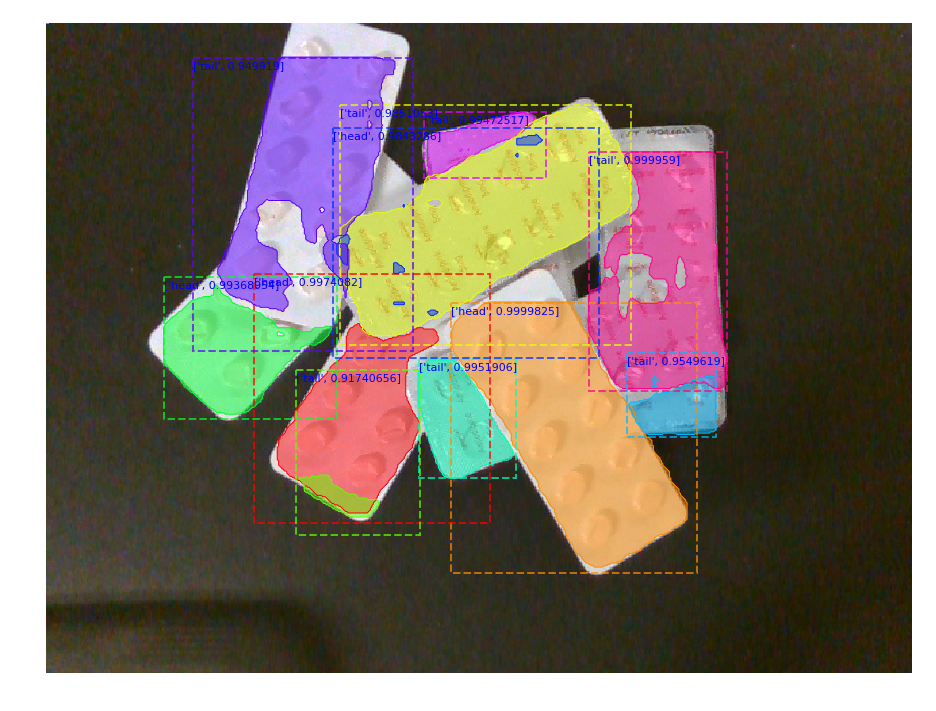

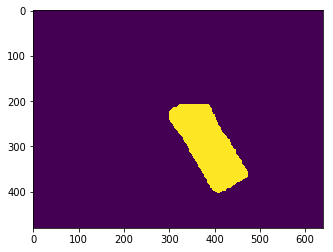

17808


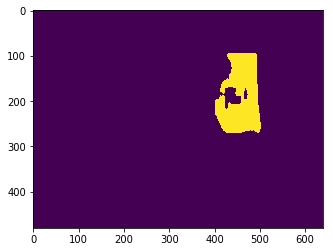

12441


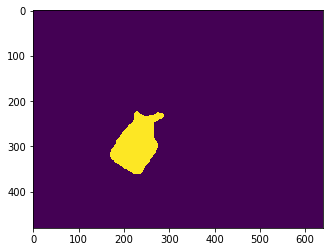

9446


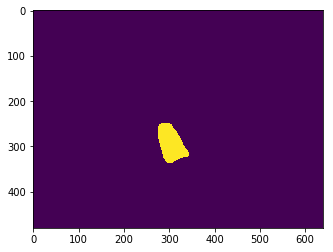

3896


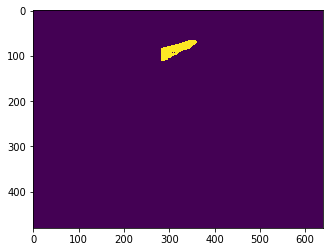

1664


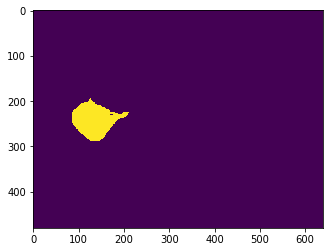

6286


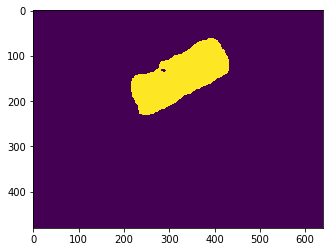

19397


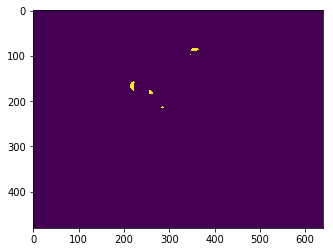

340


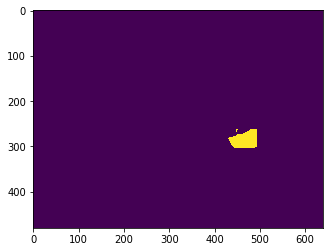

2003


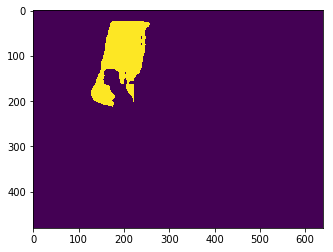

13102


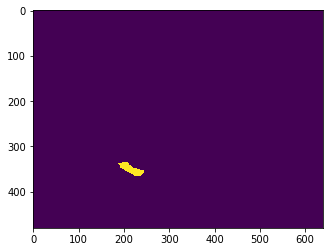

857


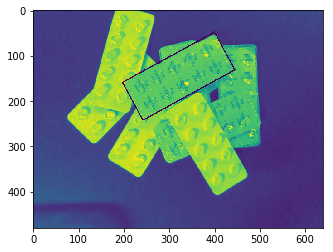

[[242 242]
 [197 159]
 [400  48]
 [445 131]]


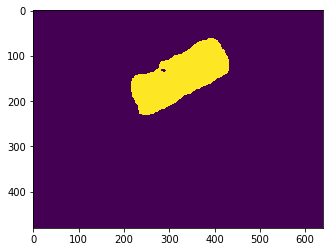

rotation 222
321.0 145.0
-118.46516214265485
0.0002842105263157874   -0.041282706766917296
0
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


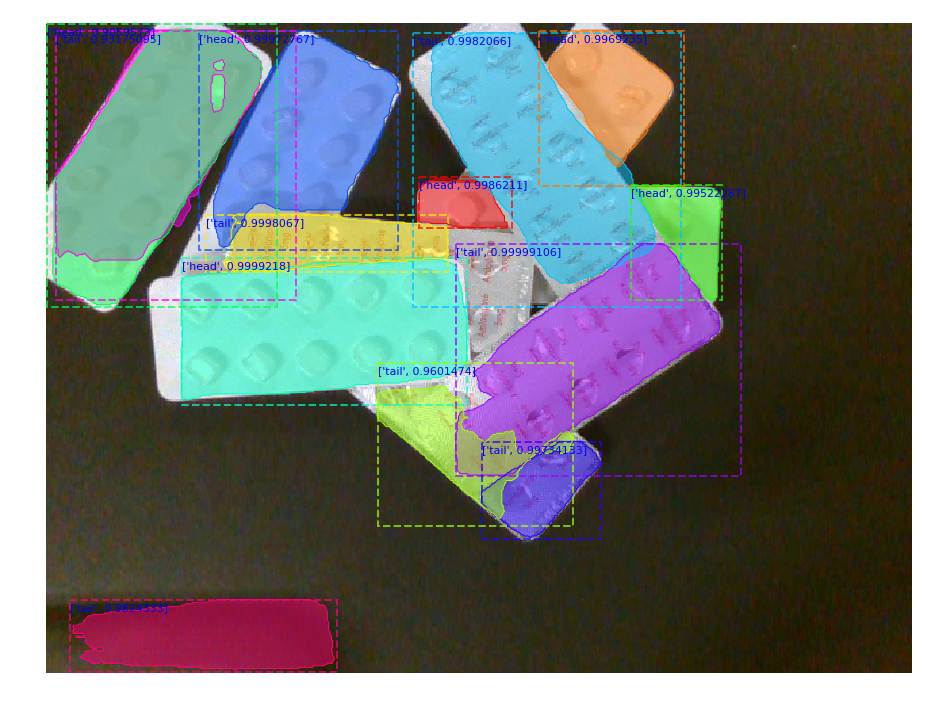

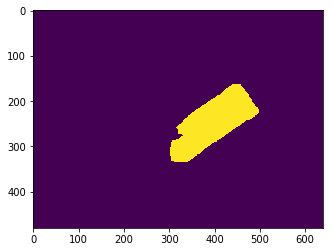

16198


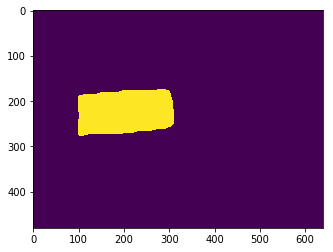

18803


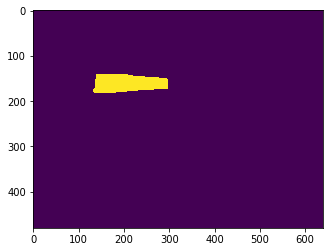

5531


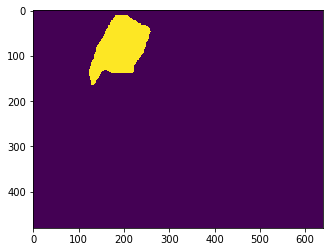

12065


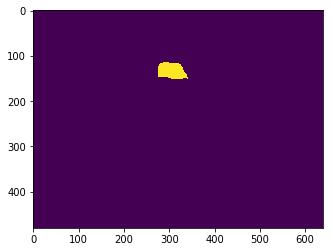

1910


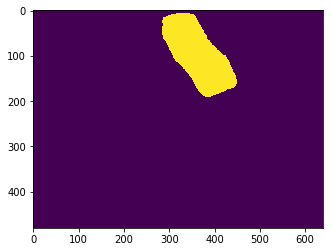

16849


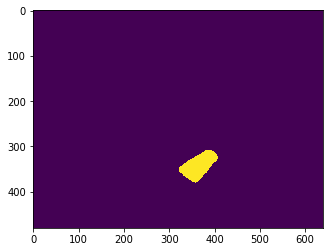

3414


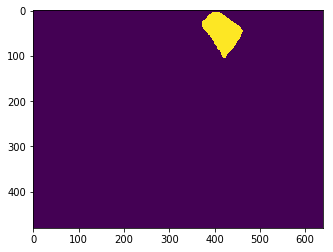

5167


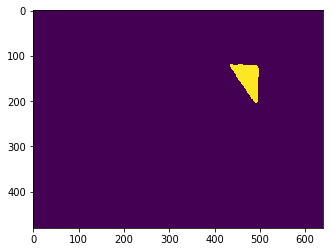

3009


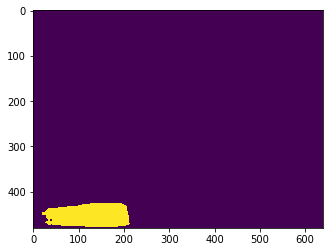

8342


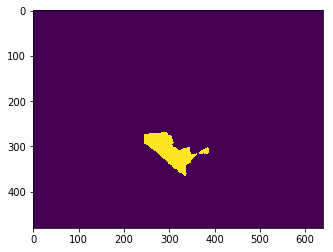

5150


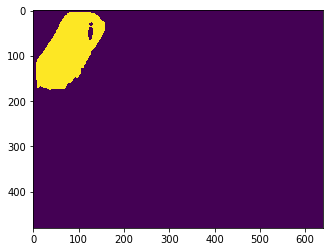

16006


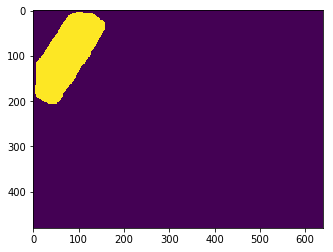

17436


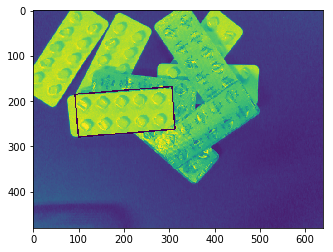

[[100 279]
 [ 92 185]
 [306 168]
 [313 262]]


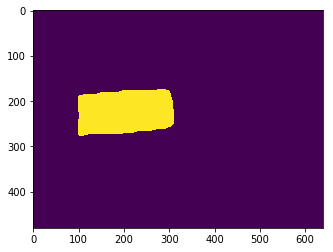

rotation 222
203.0 223.5
-94.86451443776053
-0.052948872180451134   -0.005869172932330823
0
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


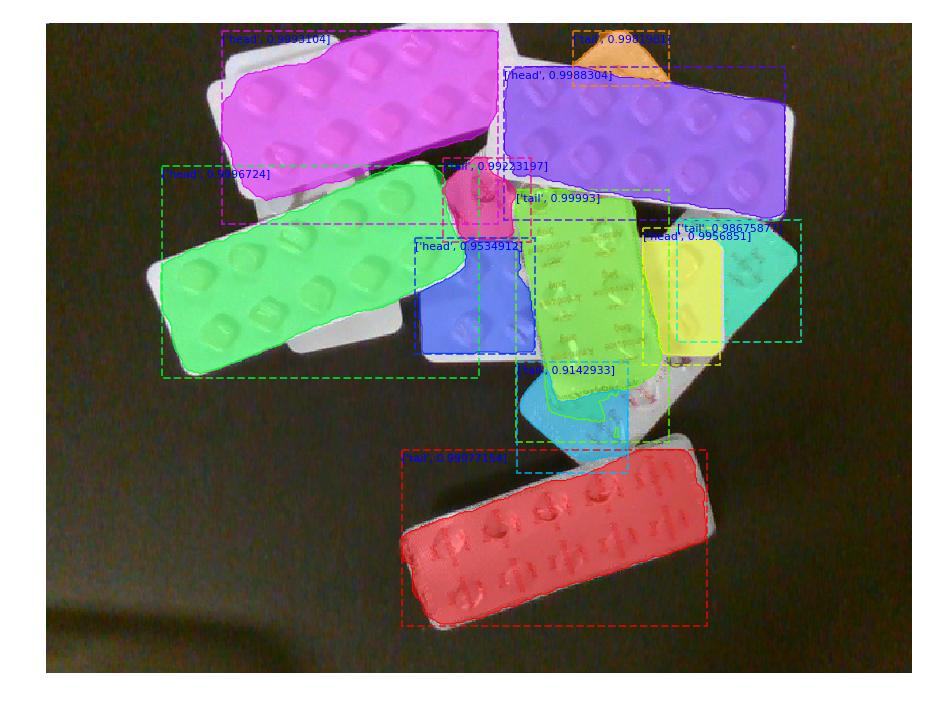

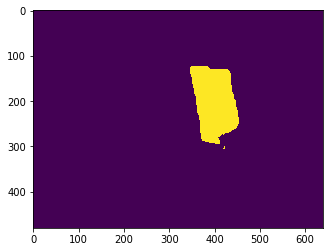

13188


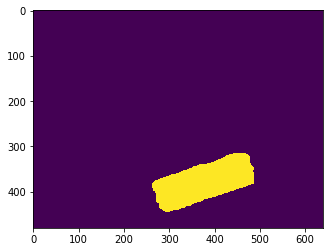

16763


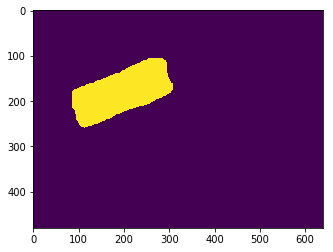

19357


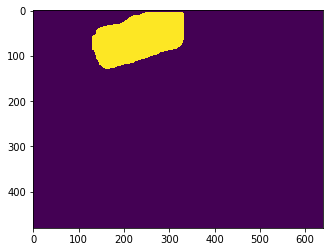

18049


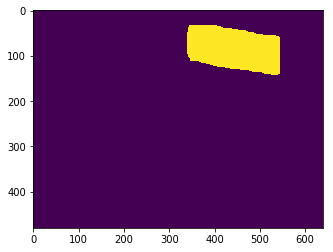

17630


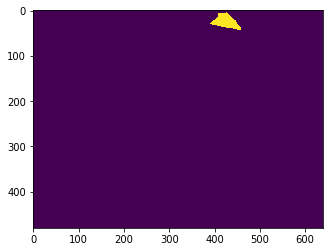

1402


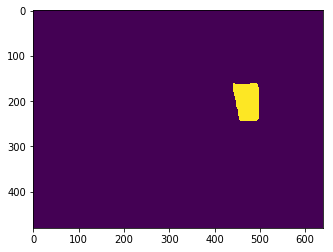

4183


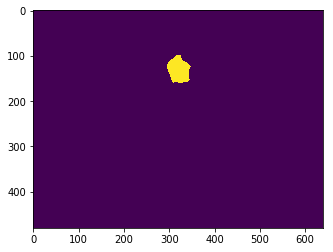

2316


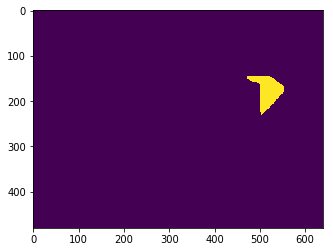

3257


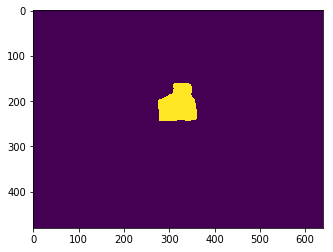

5553


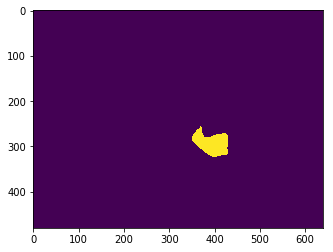

3234


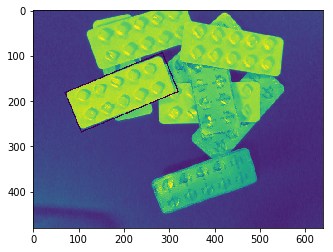

[[106 268]
 [ 70 181]
 [285  93]
 [320 179]]


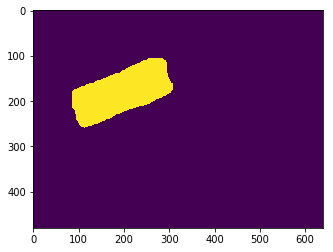

rotation 222
195.5 180.5
-112.47943439710313
-0.05633233082706767   -0.02526766917293233
1
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


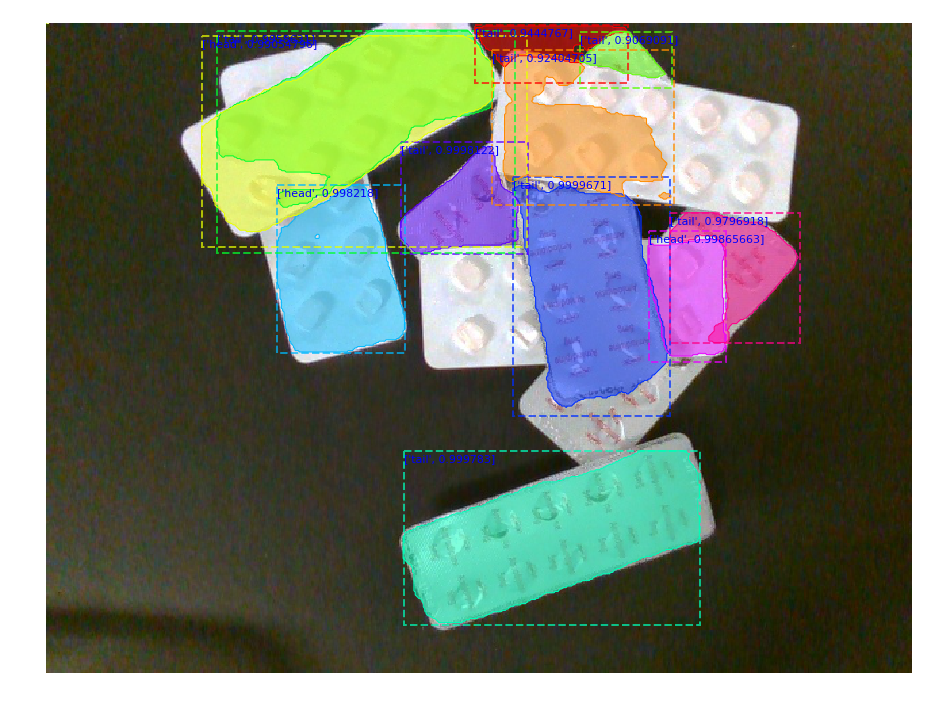

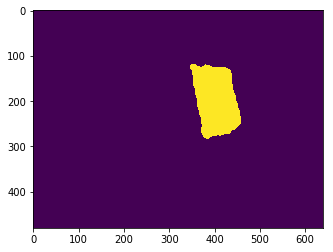

13048


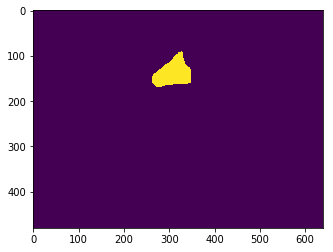

4149


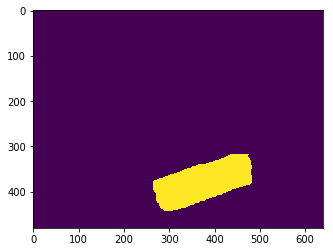

16491


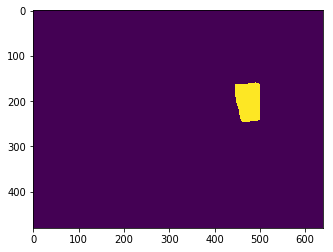

4192


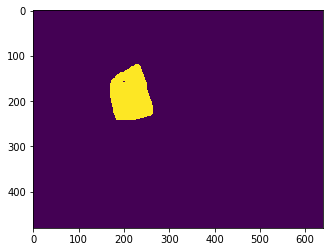

8769


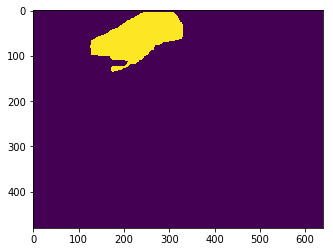

14663


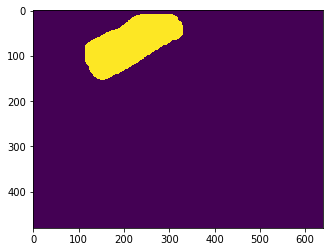

18109


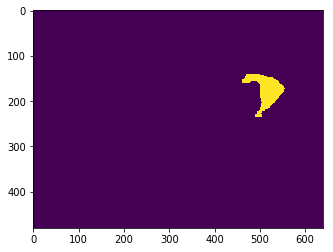

3659


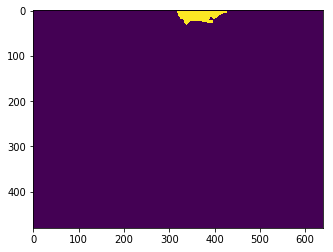

2067


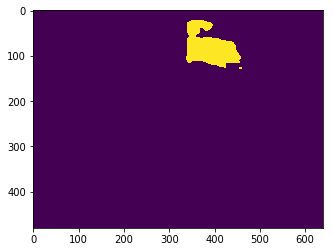

7669


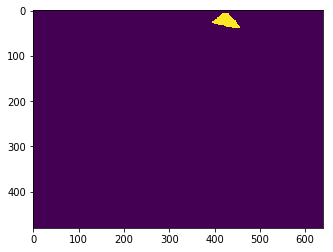

1163


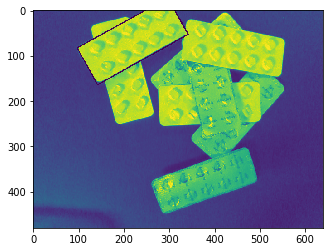

[[142 164]
 [ 97  83]
 [297 -27]
 [342  53]]


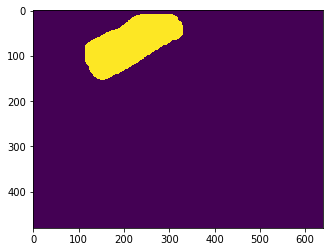

rotation 222
219.5 68.5
-119.05460409907714
-0.04550526315789474   -0.07579398496240601
2
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


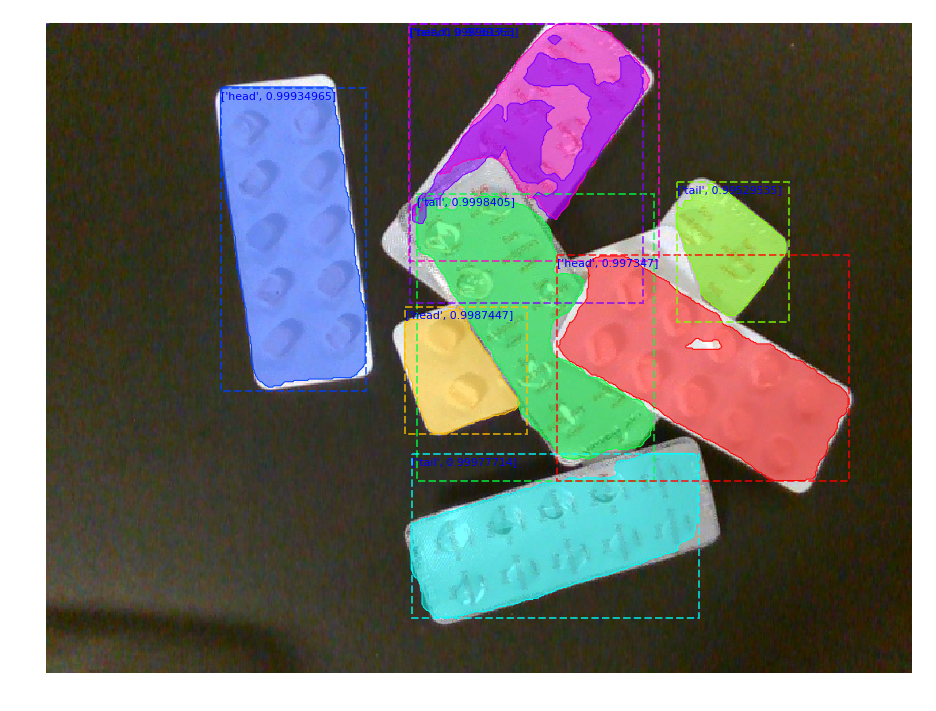

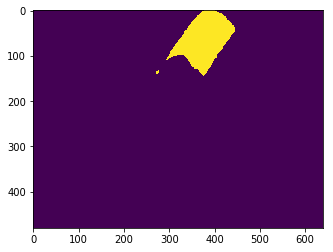

11242


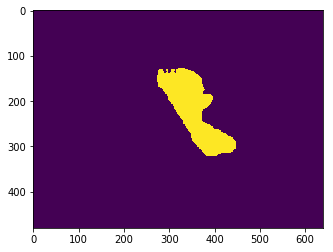

14689


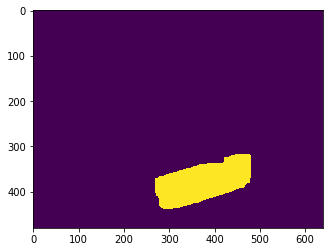

16018


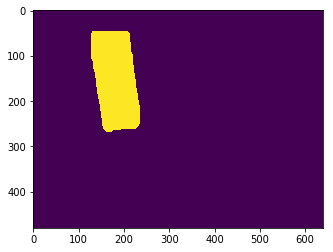

18888


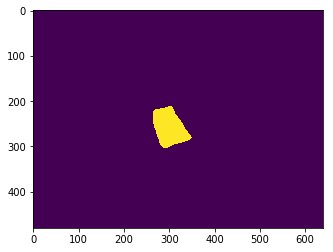

5022


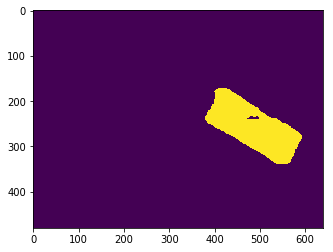

17402


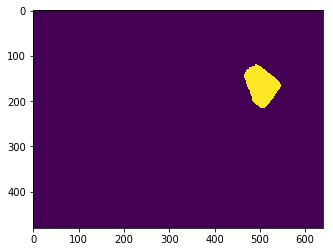

4817


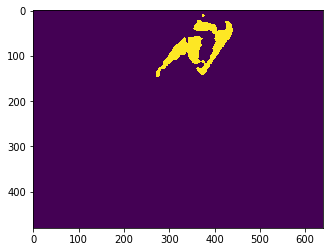

6700


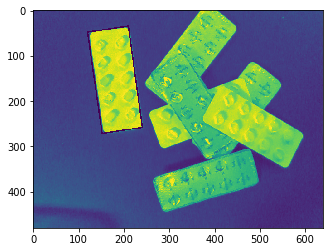

[[152 271]
 [120  48]
 [210  35]
 [241 258]]


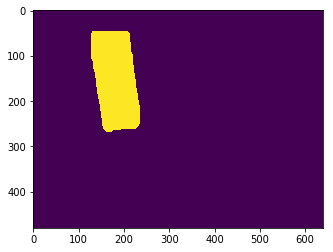

rotation 111
181.0 153.0
-8.21920924889906
-0.06287368421052632   -0.03767368421052631


KeyboardInterrupt: 

In [11]:
# from camera calibration
cx = 320.37#312.8339
cy = 236.51#247.5236
fx = 508.6722
fy = 511.8043

while(True):
    
    if(is_detect == 1):
        pose_pub = rospy.Publisher('/blister_pose', blister_pose, queue_size=10)
        # Load a the image
        #image = scipy.misc.imread('IMG_0393.JPG')
        image = scipy.misc.imread('/home/zhekai/catkin_ws/src/thin_obj_bin_picking/image/'+ img_index +'.jpeg')

        # Run detection
        results = model.detect([image], verbose=1)
        
        # Visualize results
        r = results[0]
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
        
        #img = cv2.imread('IMG_0393.JPG',0)
        img = cv2.imread('/home/zhekai/catkin_ws/src/thin_obj_bin_picking/image/'+ img_index +'.jpeg',0)
        #print(mask_rank(img, r['masks']))
        mask_max, box_max = mask_rank(img, r['masks'])

        plt.imshow(mask_max)
        plt.show()
        
        pose = get_mask_pose(box_max)
        print(pose['x'], pose['y'])
        print(pose['rz']*180/math.pi)
        
        blister_pose_msg = blister_pose()
        #blister_pose_msg.x = (pose['x'] - cx) / fx # transfer pixel position to camera frame coordinates
        #blister_pose_msg.y = (pose['y'] - cy) / fy
        blister_pose_msg.x = (pose['x'] - cx) * (102 / 226.1) * 0.001 # transfer pixel position to camera frame coordinates
        blister_pose_msg.y = (pose['y'] - cy) * (102 / 226.1) * 0.001 #183 165 332
        blister_pose_msg.angle = pose['rz']*180/math.pi
        pose_pub.publish(blister_pose_msg)
        print(blister_pose_msg.x, " ", blister_pose_msg.y)
        
        is_detect = 0